<div style='background-color:#f7f7f7; padding-top:30px; padding-left:20px; padding-right:20px; padding-bottom:30px'>
    <center>
        <div style='  display: block;
  font-size: 2em;
  font-weight: bold;  display: block;
  font-size: 2em;
  font-weight: bold;'>Naive Bayes Classifier for Fake news recognition
        </div>
    <center>
        <br>
    <i>Tommaso Bertola, Marco Zenari</i></center>
    <center>
    <i>All authors contributed equally to the project</i></center>
    

Starting in the 21st century the rise of social network platform has imposed the problem of fake news spreading. 
Developing algorithms able to classify short paragraphs of text has become a much relevant research area, in roder to identify for example spam, sexual explicit content and mainly fake news.  
There are mainly to approach to solve this task: machine learning classification and **statistical text classification**.
In this project we have implemented an algorithm of the second type, the **Naive Bayes**, to try to classify some short tweets and predict the veridicity of them.
We have also used the same algorithm to perform the classification of the area of interest of different tweets.
In order to improve the performances we have tokenized the text, cleaned each token and finally implemented a technique known as **feature selection**.
The detailes of these techniques will be discussed in the follow of this notebook.
We start now with a theoretical summary on the matter following Ref. [1].


## The text classification problem

In text classification problem we are given a **document space** $\mathcal{X}$ containing a set of **documents** $d\in\mathcal{X}$ and a set of **classes** $\mathcal{C}=\{c_1, c_2,..., c_j\}$ that are tipycally distinguished by a **label**.
Given a **training set** $\mathcal{D}$ the goal is to devolop a **classification function** $\gamma$ that maps documents to classes:
$$\gamma: \mathcal{X} \rightarrow \mathcal{C}$$

Naive Bayes is actually a **supervised learning method** $\Gamma$ that takes in input a training set and returns a classifier:
$$\Gamma\left(\mathcal{D}\right)=\gamma$$

Once we have learned the classification function $\gamma$ we can apply it on a **test set** and make prediction about the class of a given document $d$.

## Naive Bayes text classification

In this section we introduce the **multinomial Naive Bayes** which is the particular algorithm that we have implemented and it is a probabilistic learning method.

The probability of a document $d$ being in class $c$ is given by the Bayes theorem:

$$P(c|d)\propto P(c) \prod_{1\le k\le n_d} P(t_k|c)$$

where $P(t_k|c)$ is the conditional probability of **term** $t_k$ occurring in a document of class $c$.

After computing the posterior probability of each class we choose the class with the highest probability.

We note that in the previous equation different conditional probabilities are multiplied, leading to small value to deal with. 
For this reason we take the logarithm of the probabilities to compute the posterior and only at the end the exponential of the result.

Now the problem is to estimate the parameters $P(c)$ and $P(t_k|c)$. 
The first one is the prior of each class and is therefore estimated as
$$ P(c)=\frac{N_c}{N} $$
where $N_c$ is the number of documents in class $c$ and $N$ is the total number of document in the training set.

The conditional probability could be naively estimated as
$$P(t|c)=\frac{T_{ct}}{\sum_{t'\in\mathcal{V}}T_{ct'}}$$
where $T_{ct}$ is the number of occurences of term $t$ in the training documents of class $c$ and $\mathcal{V}$ is the vocabulary of the training set. 
In this case we include multiple occurences of a term in the document making a positional indipendence assumption.
The problem with this definition is that in the case that a particular term does not occur in the training data the conditional probability is zero, that being multiplied with the rest of the condtional probabilities and the prior returns a final zero.
In order to deal with that we introduce the **Laplace smoothing** that basically consist in counting at least one appearence of each term in the training set adding a $+1$ both at numerator and denominator:

$$P(t|c)=\frac{T_{tc}+1}{\sum_{t'\in\mathcal{V}}(T_{ct'}+1)}=\frac{T_{ct}+1}{\sum_{t'\in\mathcal{V}}T_{ct'}+B}$$
where $B=|V|$ is the number of terms in the vocabulary.

# The implementation of the algorithm

For simplicity sake, we moved all functions required to run the algorithm in a separate file `naive_bayes.R` which we load at the beginnig of the document.

In [1]:
source('naive_bayes.R') # load the proper functions to perform the computations

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
numCores <- detectCores() # for the parallel execution of code later on

# Reading the data and deciding what to analyze
We decide which dataset to analyze based on the variable `dataset`.
- `1` corresponds to `archive` dataset (_Ref. [2]_)
- `2` corresponds to `archive` dataset, but with categorical destinction
- `3` corresponds to `fake-news` dataset (_Ref. [3]_)
- `4` corresponds to `fake-news` dataset, but focusing on titles

In [3]:
dataset <- 1

In [4]:
# possible paths for the 2 datasets

train1.filename <- "dataset/archive/train.csv"
test1.filename <- "dataset/archive/test.csv"

train2.filename <- "dataset/fake-news/train.csv"
test2.filename <- "dataset/fake-news/test.csv"

In [5]:
# a simple if statement to normalize the dataset to use giving the proper names
# to the columns to be used by the algorithm; it also initializes the
# tags_numers object to keep track of labels names, numbers and colors for
# plotting
if (dataset == 1) {
    train.df <- read.delim(train1.filename, sep = ",")
    test.df <- read.delim(test1.filename, sep = ",")

    tags_numbers <- list(tags = c("Barely True", "False", "Half-True", "Mostly-True",
        "Not known", "True"), numbers = c(0:5), colors = c("#FF6666", "#FF9966",
        "#FFCC66", "#99FF99", "#CCCCCC", "#00FF99"))

} else if (dataset == 2) {
    train.df <- read.delim(train1.filename, sep = ",")
    test.df <- read.delim(test1.filename, sep = ",")

    train.df %>%
        filter(grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 0) -> economy

    train.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 1) -> health_care

    train.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 2) -> taxes

    train.df <- rbind(economy, health_care, taxes)

    test.df %>%
        filter(grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 0) -> economy_test

    test.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 1) -> health_care_test

    test.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 2) -> taxes_test

    test.df <- rbind(economy_test, health_care_test, taxes_test)

    tags_numbers <- list(tags = c("Economy", "Health-Care", "Taxes"), numbers = c(0:2),
        colors = c("#32D2FC", "#FCEA19", "#FF0759"))

} else if (dataset == 3) {
    train.df <- read.delim(train2.filename, sep = ",")
    test.df <- read.delim(test2.filename, sep = ",")

    train.df %>%
        filter(!text == "") %>%
        filter(!text == " ") %>%
        filter(!text == " ") %>%
        select(label, text) %>%
        rename(Labels = label, Text = text) -> train.df

    test.df %>%
        filter(!text == "") %>%
        filter(!text == " ") %>%
        select(text) %>%
        rename(Text = text) -> test.df

    tags_numbers <- list(tags = c("Reliable", "Unreliable"), numbers = c(0:1), colors = c("#36B1FF",
        "#EF8D00"))

} else if (dataset == 4) {
    train.df <- read.delim(train2.filename, sep = ",")
    test.df <- read.delim(test2.filename, sep = ",")

    train.df %>%
        filter(!title == "") %>%
        filter(!title == " ") %>%
        select(label, title) %>%
        rename(Labels = label, Text = title) -> train.df

    test.df %>%
        filter(!title == "") %>%
        filter(!title == " ") %>%
        select(title) %>%
        rename(Text = title) -> test.df

    tags_numbers <- list(tags = c("Reliable Title", "Unreliable Title"), numbers = c(0:1),
        colors = c("#36B1FF", "#EF8D00"))
}

# Display the train dataset
This is done in order to check the dataset schema.

`test.df` does not have the assigned Labels. We therefore are going to split the training dataset in actual training and validation sets to check the accuracy of the algorithm. 

In [6]:
head(train.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


In [7]:
head(test.df)

,Text,Text_Tag
,<chr>,<chr>
1,Building a wall on the U.S.-Mexico border will take literally years.,immigration
2,Wisconsin is on pace to double the number of layoffs this year.,jobs
3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


# Splitting the dataset into train and validation
This is the standard procedure to assess the accuracy of any algorithm running on data

In [8]:
set.seed(29062023) # seed for code reproducibility
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [9]:
# set splitting percentages
perc_split <- 0.8  # 80% of original dataset is for training and 20% for validation
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

# splitting
train.df.train <- train.df[1:n_rows_train, ] # takes the first n_rows
train.df.validation <- train.df[-c(1:n_rows_train), ] # takes the remaining rows

In [10]:
# show the splitted datasets number of rows
cat("Total rows:", nrow(train.df),
    "\nTrain rows:", nrow(train.df.train),
    "\nValidation rows:", nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows: 2048

# Labels distribution and prior definition
This is a necessary step in oder to check the distribution of the labels, and therefore compute the associated prior probabilities.

In [11]:
counts_labels <- table(train.df.train$Labels)  # count each label

In [12]:
n_classes <- length(counts_labels)  # count the number of different labels

## Defining the prior of each class

In [13]:
prior.classes <- counts_labels/sum(counts_labels)  # compute the prior for each kind of label

## Show the label distribution in a barplot

In [14]:
labels <- tags_numbers$tags
colors <- tags_numbers$colors

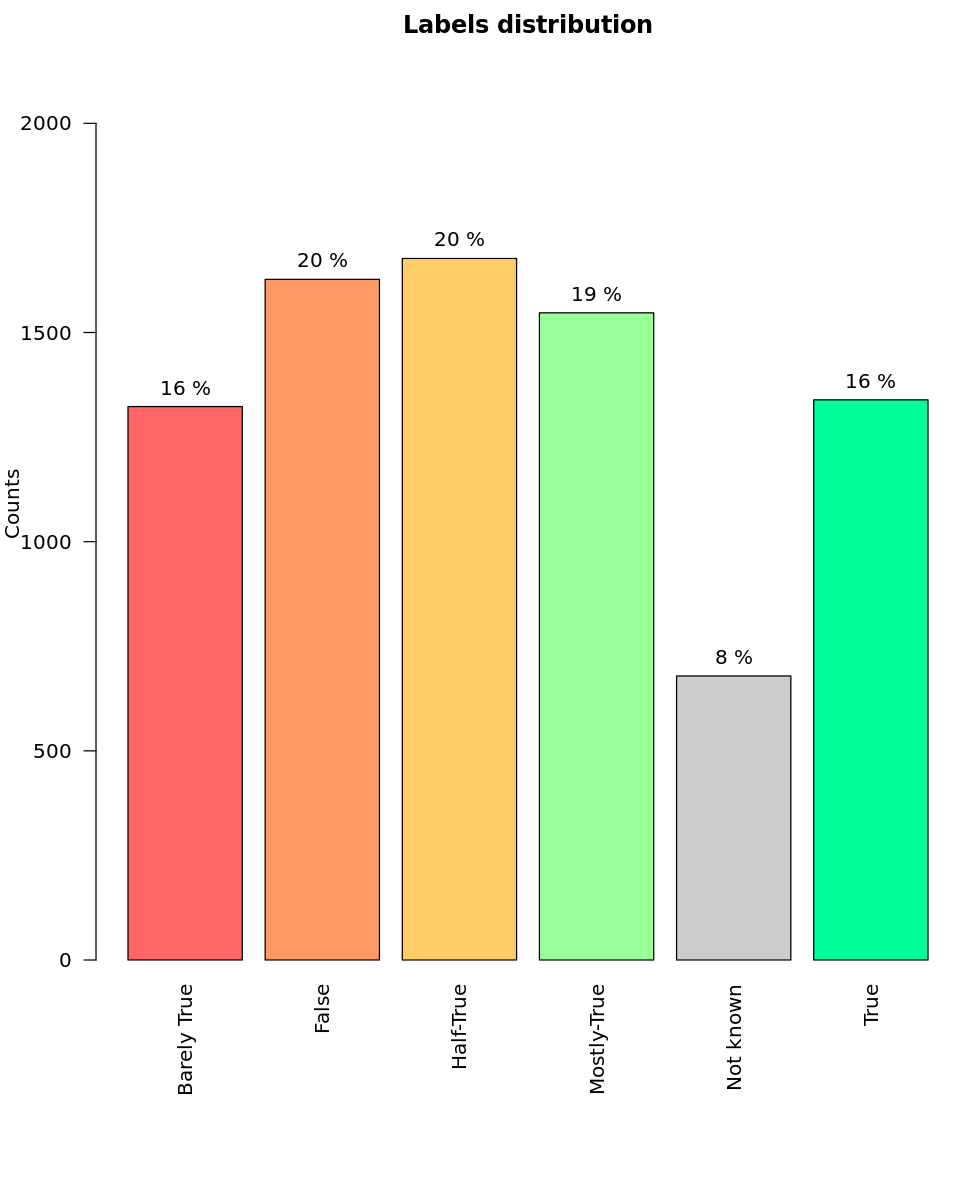

In [15]:
options(repr.plot.height = 10, repr.plot.width =8)

par(mar = c(10, 4, 2, 0))
b <- barplot(counts_labels, col = colors, names = labels, las = 2, ylab = "Counts",
    main = "Labels distribution", ylim = c(0, 1.3 * max(counts_labels)))
text(x = b, y = counts_labels, pos = 3, label = paste(round(prior.classes * 100,
    0), "%"), cex = 1)

# Stop words: those to be ignored
We decided to use the `tidytext` library which already implements a list of the most common stop words in English as shown below. All these words will be removed from the vocabulary when performing the Naive Bayes computations. 

In [16]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Example on prediction with data
Here is the code to be run in order to classify the messages.

We are showing only the fastest method to classify the messages: the feature selection based on the frequency.
Other feature selection methods were used, but they require more time to be run. They are compared below.

This is the flowchart used in the code to classify all the messages. Note that the code below does not use the wrappers described in the diagram in order to accurately show the decision making process.

<img src='flowchart.png' width='75%'>

The list of possible feature selection methods is the following:
- feature_selection.frequency_per_mean
- feature_selection.frequency_per_class
- feature_selection.chi_squared_per_mean
- feature_selection.chi_squared_per_class
- feature_selection.mutual_info_per_class
- feature_selection.mutual_info_per_mean

In [17]:
# get the countings for all the words
counts <- vocabulary(train.df.train, tags_numbers)

# vocabulary optimized with feature selection (other methods are discussed below)
naive.bayes.vocabulary <- feature_selection.frequency_per_mean(counts, n_classes, frac = 0.7)

# compute denominator of likelihood (for optimization issues, this is done outside other functions)
denominator <- likelihood.denominator(naive.bayes.vocabulary)

# compute the likelihood dataframe for each tokenized and unique word
likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

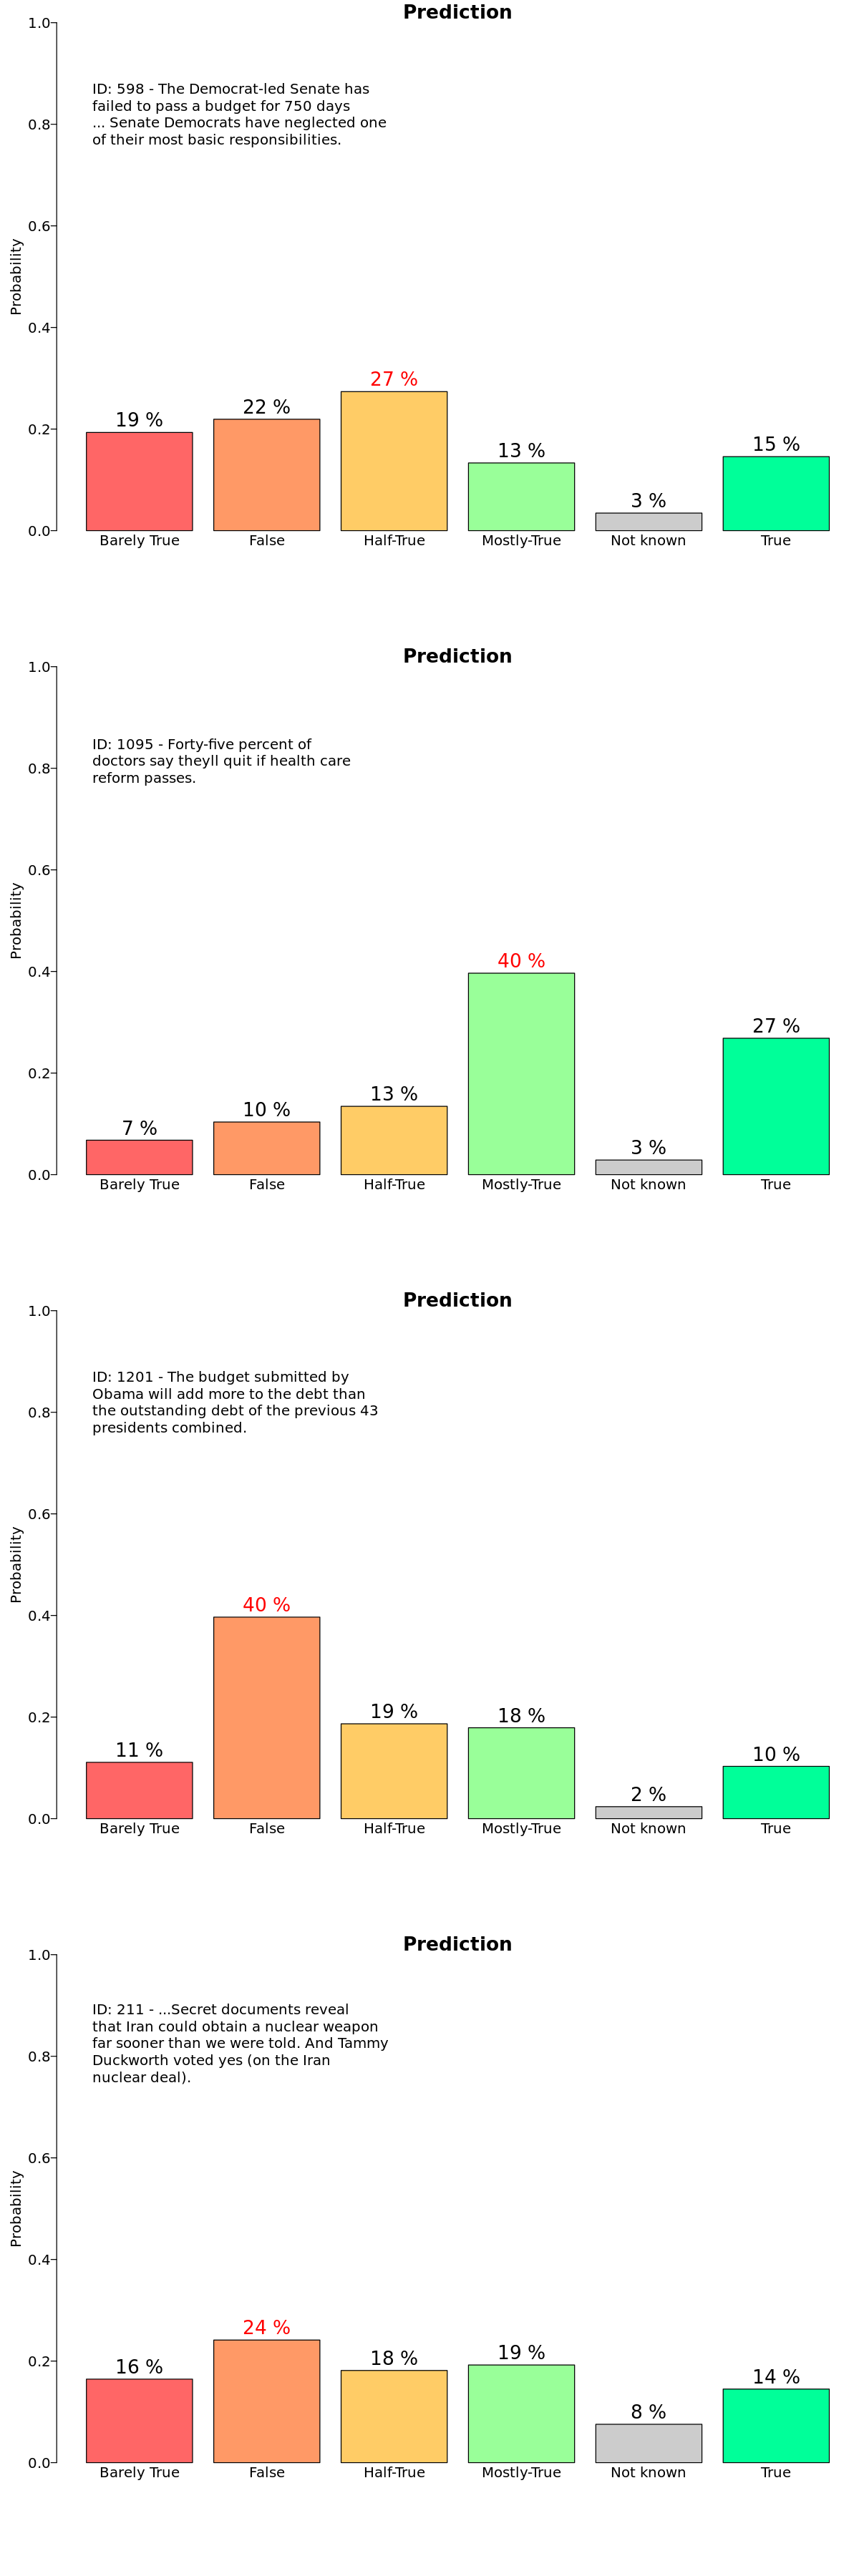

In [18]:
# plotting configurations
options(repr.plot.height = 30, repr.plot.width = 10)
par(mar = c(10, 5, 2, 0), mgp = c(3, 0.5, 0), mfrow = c(4, 1), cex.axis = 1.5, cex.lab = 1.4,
    cex.main = 2)

# show 4 examples
for (i in 1:4) {
    id_msg <- floor(runif(n = 1, min = 1, max = nrow(test.df)))
    # get the text of the message from the test dataset
    msg <- test.df$Text[id_msg]

    # tokenize single message
    token.list <- as.vector(tweet_tokenize(msg))

    # compute the posterior of being in each class
    probability <- bayes.probability(token.list, likelihood.token, prior.classes,
        denominator, n_classes)

    # get the predicted label, according to the max probability index
    predicted.label <- which.max(probability)

    # plot the probabilities for each class
    b <- barplot(probability, col = colors, names = labels, las = 1, ylab = "Probability",
        main = paste("Prediction"), ylim = c(0, 1), cex.lab = 1.5)

    text(x = b, y = probability, pos = 3, label = paste(round(probability * 100,
        0), "%"), cex = 2, col = c(rep("black", predicted.label - 1), "red", rep("black",
        n_classes - predicted.label)))

    text(x = 0.2, y = 0.8, labels = paste(strwrap(str_trunc(paste("ID:", id_msg,
        " - ", msg), 300), width = 40), collapse = "\n"), cex = 1.5, pos = 4)
}

To evaluate the performances of the naive Bayes algorithm, we run it with the validation dataset, keeping count of how many guesses are correct.

In [19]:
# run the prediction in parallel
predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
                              likelihood.token = likelihood.token,
                              prior.classes = prior.classes, den = denominator, 
                              n_classes = n_classes, mc.cores = numCores)

# Check % of right predictions
accuracy <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)

In [20]:
cat('Accuracy of NB:', accuracy)

Accuracy of NB: 0.215332

# Accuracies for the datsets
We report below a summary table showing the percentage accuracies of the NB classifier run on the four different datasets with a feature selection carried out by the `frequency_per_mean` function with a 70% retaining fraction on the vocabulary.

|Dataset|Accuracy [%]|Accuracy by chance [%]|
|:--:|:--:|:--:|
|1|22|17|
|2|48|33|
|3|69|50|
|4|68|50|

# Feature selection methods
To check how accurate the algorithm is, as suggested in Ref. [1], we performed some `feature selection` with different techniques.

The feature selection process allows to use a smaller but more meaningful vocabulary to compute the likelihoods of the words in the documents. The whole vocabulary is filtered as to retain only a certain fraction of words by their importance defined by an arbitrary metric.

We used three different metrics:
- **frequency based**
- **mutual information**
- **chi squared**

which computed the feature importance of each word in each class in the original vocabulary.

The aim of the feature selection is to filter out the less useful words in classifying the documents. It allows to remove the noise made of spurious words that would otherwise alter the predictions of the Naive Bayes classifier.

## Frequency based
The first metric computes the importance of a word simply as the frequency it appears in the training dataset for each class. 

|Word| # in class 1|# in class 2|...|
|--:|--:|--:|--:|
|word1|12|6|...|
|word2|5|2|...|
|...|...|...|...|
|**Sum**|$\sum_1$=12+5+...|$\sum_2$=6+2+...|...|

Each word counting is then normalized to the sum of countings in each class, $\sum_i$, thus yielding a probability.

In [21]:
# a simplified example of the output of vocabulary_frequency
frequency <- vocabulary_frequency(counts)

# show highest and lowest words by frequency mean
frequency %>%
    mutate(mean = rowMeans(pick(where(is.numeric), -word))) %>%
    arrange(desc(mean)) %>%
    {
        rbind(head(., 5), tail(., 5))
    }

,word,Barely True,False,Half-True,Mostly-True,Not known,True,mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,--number--,0.039590894,0.045591251,0.13193220,0.05533041,0.011161511,0.0438545539,0.0545768032
2,say,0.020968866,0.027515671,0.02809296,0.04528814,0.010807160,0.0136588349,0.0243886046
3,state,0.008001631,0.012430297,0.01478060,0.01619959,0.008135593,0.0128335022,0.0120635357
4,year,0.008668243,0.008664186,0.01260455,0.01478060,0.003075871,0.0241355932,0.0119881747
5,percent,0.008270677,0.017491525,0.01215805,0.01238469,0.001974907,0.0126031013,0.0108138258
9055,vaccinate,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.0000509658,0.0000084943
9056,volvo,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.0000509658,0.0000084943
9057,wasgovernor,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.0000509658,0.0000084943
9058,wiretap,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.0000509658,0.0000084943


## Mutual information
Another useful criterion involves the computation of the mutual information of each word. It is computed with the following formula: 

$$\text{MI}(\text{word, class})=\frac{N_{11}}{N}\log_2\frac{NN_{11}}{N_{1.}N_{.1}}+
\frac{N_{01}}{N}\log_2\frac{NN_{01}}{N_{0.}N_{.1}}+
\frac{N_{10}}{N}\log_2\frac{NN_{10}}{N_{1.}N_{.0}}+
\frac{N_{00}}{N}\log_2\frac{NN_{00}}{N_{0.}N_{.0}}$$

where:
- $N_{11}$ is the number of documents that **contain the word** and **are in the class** considered
- $N_{10}$ is the number of documents that **contain the word** and **are not in the class** considered
- $N_{01}$ is the number of documents that **do not contain the word** and **are in the class** considered
- $N_{00}$ is the number of documents that **do not contain the word** and **are not in the class** considered

And $N_{1.} = N_{10} + N_{11}$ is the number of documents that contain the word independently of thier class and, following the same convention of the indexes $N_{0.}$, $N_{.1}$, and $N_{.0}$ are also defined.
Finally $N = N_{00} + N_{01} + N_{10} + N_{11}$ is the total number of documents.

In [22]:
# a simplified example of the output of vocabulary_mutual_information
# the higher the mutual information, the more significant is that word
# to help classify a document in that class
mutual_info <- vocabulary_mutual_info(counts[1:200,], train.df.train[1:5000,], n_classes,
    numCores)

# show highest and lowest words by mutual information mean
mutual_info %>%
    mutate(mean = rowMeans(pick(where(is.numeric), -word))) %>%
    arrange(desc(mean)) %>%
    {
        rbind(head(., 5), tail(., 5))
    }

,word,V1,V2,V3,V4,V5,V6,mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,--number--,2.535330e-04,5.854053e-03,2.456090e-03,3.313673e-03,2.836639e-03,4.216136e-04,2.522600e-03
2,obama,1.200736e-03,6.841716e-04,6.280951e-05,2.469611e-03,3.128941e-03,2.700845e-03,1.707853e-03
3,care,1.429343e-03,1.031028e-03,5.091331e-06,1.543038e-03,7.101802e-04,3.115793e-03,1.305746e-03
4,percent,2.914991e-04,2.140598e-03,3.661950e-04,3.174588e-03,1.497519e-03,6.216842e-05,1.255428e-03
5,since,7.756403e-04,1.982634e-03,5.271999e-04,8.117965e-04,1.807299e-03,1.458758e-03,1.227221e-03
196,insurance,5.531629e-05,2.739490e-05,8.993947e-05,5.000762e-05,8.882398e-06,6.246428e-06,3.963118e-05
197,city,1.182383e-04,2.247083e-06,1.410503e-05,6.982795e-05,3.211821e-05,6.336797e-07,3.952837e-05
198,court,4.105694e-05,8.876625e-06,4.414721e-05,3.027978e-05,4.189588e-05,6.907866e-05,3.922252e-05
199,real,1.213501e-05,9.430622e-05,3.097295e-06,5.845030e-05,2.772093e-07,6.692481e-05,3.919848e-05


## Chi squared
Similarly to mutual information, chi squared metric ranks the words based on their dependance or independence from the class. It is defined as follows:
$$\chi^2(\text{word, class})=\frac{(N_{11}+N_{10}+N_{01}+N_{00})(N_{11}N_{00}-N_{10}N_{01})^2}{(N_{11}+N_{01})(N_{11}+N_{10})(N_{10}+N_{00})(N_{01}+N_{00})}$$

with analogous meanings of the $N_{..}$ to the definitions above.

In [23]:
# a simplified example of the output of vocabulary_chi_squared
# the higher the chi squared, the more significant is that word
# to help classify a document in that class
chi_squared <- vocabulary_chi_squared(counts[1:200,], train.df.train[1:5000,], n_classes,
    numCores)

# show highest and lowest words by chi squared mean
chi_squared %>%
    mutate(mean = rowMeans(pick(where(is.numeric), -word))) %>%
    arrange(desc(mean)) %>%
    {
        rbind(head(., 5), tail(., 5))
    }

,word,V1,V2,V3,V4,V5,V6,mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,--number--,1.74775428,39.56982771,17.22072749,23.272355313,18.93507708,2.940198378,17.2809900
2,obama,8.85182809,4.92697228,0.42974354,15.619020893,25.40740448,16.760999026,11.9993280
3,care,10.67806939,7.52753636,0.03514528,9.870675598,5.39308747,18.830819889,8.7225557
4,percent,1.95387835,13.71683375,2.61276953,23.832688906,9.01873659,0.437082773,8.5953316
5,since,4.82959992,11.85754717,3.88594893,6.071669315,9.15775776,11.322592221,7.8541859
196,city,0.86453141,0.01547760,0.09934379,0.465751979,0.21135906,0.004374671,0.2768064
197,insurance,0.39746138,0.18581006,0.59793911,0.356861273,0.05999130,0.043821012,0.2736474
198,real,0.08644153,0.69304327,0.02172125,0.383246230,0.00190756,0.433243465,0.2699339
199,court,0.27309273,0.06243195,0.29524150,0.215840739,0.27031806,0.502157026,0.2698470


# Selecting the words with higher rankings
After computing the importances for each word in each category, we selected only the most relevant ones.

There are two ways of doing this: by ranking the feature importance of each word separately for each class or by ranking the mean feature importance among all classes.

We implemented both ways as can be seen in the functions `ranking_per_mean` and `ranking_per_class`.

# Effects of feature selection set size on accuracy
To check if different feature selections criteria yielded different accuracies we plot the accuracy as a function of the retained fraction of the vocabulary, using all the different methods.

```{r}
fraction <- seq(from = 0.1, to = 0.9, by = 0.2) # the fractions tested

# return the whole data.frame with counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

# for each feature selection and ranking method, save to a file the vocabulary
for (i in seq_along(fraction)) {

    # frequency_per_class
    write.csv(feature_selection.frequency_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/frequency_per_class", fraction[i], ".csv", sep = ""))
        
    # frequency_mean
    write.csv(feature_selection.frequency_per_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/frequency_per_mean", fraction[i], ".csv", sep = ""))
        
    # chi_squared_per_class
    write.csv(feature_selection.chi_squared_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/chi_per_class", fraction[i], ".csv", sep = ""))
        
    # chi_squared_per_mean
    write.csv(feature_selection.chi_squared_per_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/chi_per_mean", fraction[i], ".csv", sep = ""))
        
    # mutual_info_per_class
    write.csv(feature_selection.mutual_info_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/mutual_per_class", fraction[i], ".csv", sep = ""))
        
    # mutual_info_per_mean
    write.csv(feature_selection.mutual_info_per_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/mutual_per_mean", fraction[i], ".csv", sep = ""))
}
```

## Apply to the validation set and plot accuarcies for different methods
After saving the vocabularies to save time in later computations, we apply the prediction functions to get the accuracies for each method at different retaining probabilities.

```{r}
# the saved vocabularies depending on feature selection method and retained fraction
file_list <- c(list.files(path = "models", pattern = "frequency_per_mean*"),
               list.files(path = "models", pattern = "frequency_per_class*"),
               list.files(path = "models", pattern = "chi_per_mean*"),
               list.files(path = "models", pattern = "chi_per_class*"),
               list.files(path = "models", pattern = "mutual_per_class*"),
               list.files(path = "models", pattern = "mutual_per_mean*"))

# the vector where all accuracies are saved
acc <- vector()

# for each method and retained fraction
for (i in seq_along(file_list)) {

    # load the feature selected vocabulary
    naive.bayes.vocabulary <- read.csv(paste("./models", file_list[i], sep = "/")) %>%
                              select(-X)
                              
    # compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # compute the likelihood for each tokenized and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # run the prediction in parallel
    predicted_classes <- mclapply(X = train.df.validation$Text,
                                  FUN = naive.bayes,       
                                  likelihood.token = likelihood.token,
                                  prior.classes = prior.classes,
                                  den = denominator,
                                  n_classes = n_classes,
                                  mc.cores = numCores)

    # Check % of right predictions and save them to vector
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}
```

## Plotting the accuracy for different methods - Dataset 1
We finally plot the accuracy computed on the validation dataset of the NB classifier run with different vocabularies for the first dataset.

It is clear that overall the accuracy is quite low, around 20%, which is not such a good performance as blindly guessing would have returned an accuracy of 100/6% ~ 17%.
Only the `frequency_per_mean` method for a fraction of 70% retained vocabulary seems to return a better performance. For this reason and also because it is computationally less demanding, all the other datasets are classified with this feature selection method.
<img src='accuracy/feature_selection_accuracy.png'>

# References
[1] C. D. Manning, Chapter 13, Text Classification and Naive Bayes, in Introduction to Information
Retrieval, Cambridge University Press, 2008.

[2] Fake News Content Detection, KAGGLE data set: https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv

[3] Fake News: build a system to identify unreliable news articles https://www.kaggle.com/competitions/fake-news/data?select=train.csv